In [2]:
#Directory
data = 'HPTLCRaw\\'

In [3]:
import os
import natsort
import skimage
import numpy as np
import pandas as pd

In [4]:
from natsort import natsorted, ns
from skimage import io, color
from matplotlib import pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
import scipy.misc
from scipy import ndimage
%matplotlib inline 

# Color Import

In [5]:
list_files = os.listdir(data)
list_files = natsorted(list_files)
image_list = []
for filename in list_files:
    image_list.append(io.imread(data+filename)[:,:,:3])

In [129]:
# image_list[0]

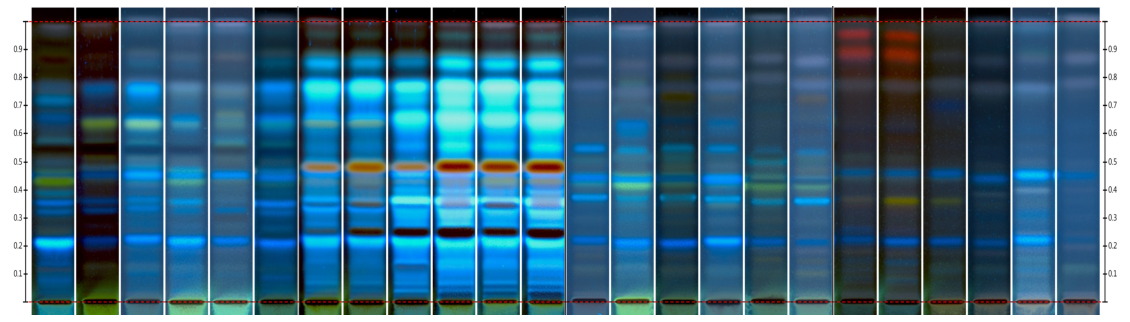

In [6]:
plt.figure(figsize = (20,10))
plt.axis('off')
plt.imshow(image_list[0])

# Grey Scale Import

In [7]:
list_files = os.listdir(data)
list_files = natsorted(list_files)
image_list = []
for filename in list_files:
    image_list.append(color.rgb2gray(io.imread(data+filename)[:,:,:3]))

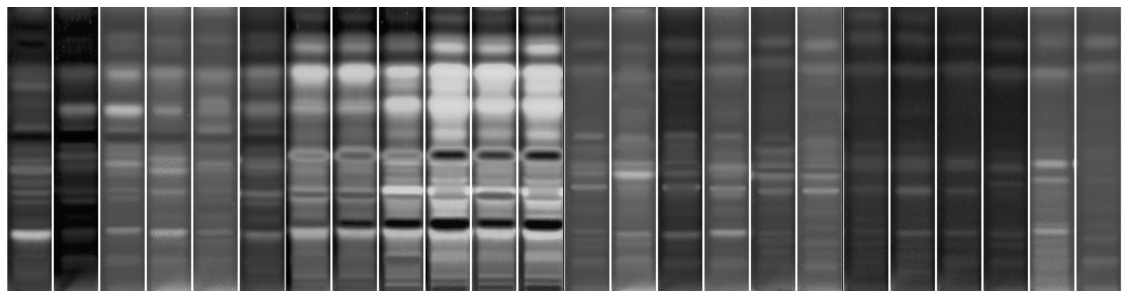

In [8]:
# crop_img = image_list[0][65:-60,90:-90]
crop_img = image_list[0][70:-71,96:-84]
# fig, ax = plt.subplots(figsize=(50, 10))
plt.figure(figsize = (20,10))
plt.axis('off')
plt.imshow(crop_img,cmap='gray') #, interpolation='nearest'

In [9]:
np.shape(crop_img)

(1075, 4220)

##### Attempt at Algorithmically Determining Crop Locations

In [24]:
det_crops = pd.DataFrame(crop_img)
np.shape(det_crops)
# det_crops

(1075, 4220)

In [34]:
col_hi_cnt = det_crops[det_crops > .3].count()

In [33]:
print(col_hi_cnt.max())
print(col_hi_cnt.min())

1075
0


In [11]:
# det_crops2 = det_crops.count(axis=0)
# np.shape(det_crops2)

(4220,)

([], [])

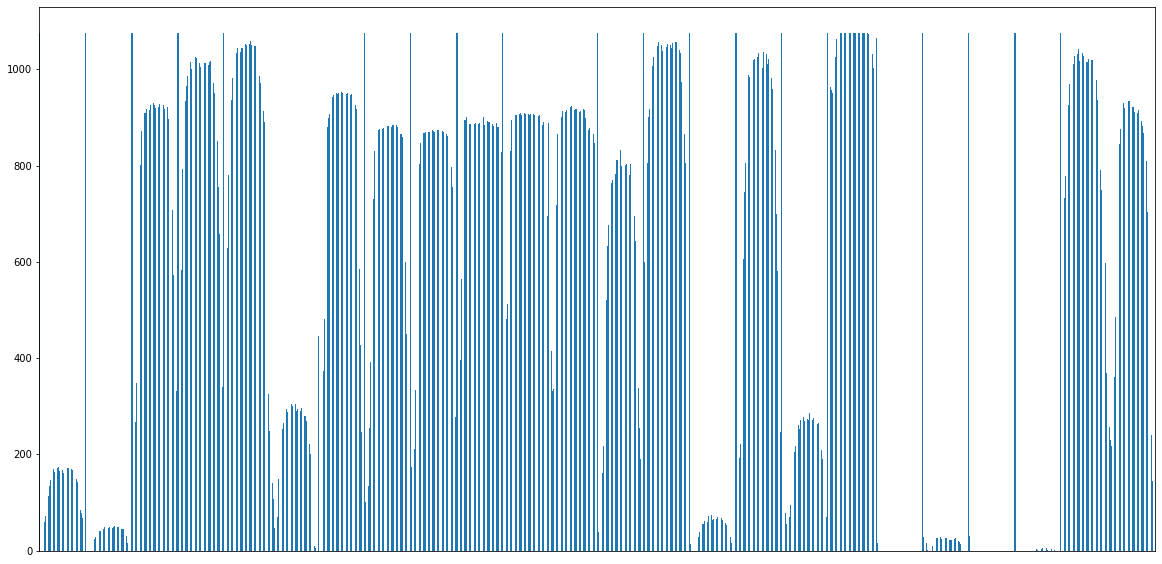

In [35]:
plt.figure(figsize = (20,10))
col_hi_cnt.plot.bar()
plt.xticks([])

##### Determing Width of a single Strip

In [12]:
single_strip = crop_img[:,:165]
single_strip[1][-1].max()
# plt.figure(figsize = (20,10))
# plt.axis('off')
# plt.imshow(single_strip,cmap='gray')

0.10854588235294117

##### Determing Padding in between Strips
-> Discovered 12 px but used 10 later regardless

In [13]:
single_strip = crop_img[:,177:342]
single_strip[1][-1].max()
# single_strip[1][0].max()
# plt.figure(figsize = (20,10))
# plt.axis('off')
# plt.imshow(single_strip,cmap='gray')

0.09218039215686274

##### Cropping and Appending Crop to new array

In [14]:
strip_array = []
cut_cnt = 1
while cut_cnt <= 24:
    #Each image is 165 Pixels Wide
    #However, due to practicalities, we will be cropping out only the central 65 pixels
    #This means that there are 50 pixels on each side of the central crop
    #Furthermore, we will also allow for 10 pixels of padding in between images for the white space
    front_crop = ((cut_cnt-1)*175) + 50
    back_crop = (cut_cnt*115)+(60*(cut_cnt-1))
    strip_array.append(crop_img[:,front_crop:back_crop])
    # print(np.shape(strip_array[-1]))
    cut_cnt += 1
arr = np.asarray(strip_array)

In [16]:
# np.shape(strip_array[i])

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

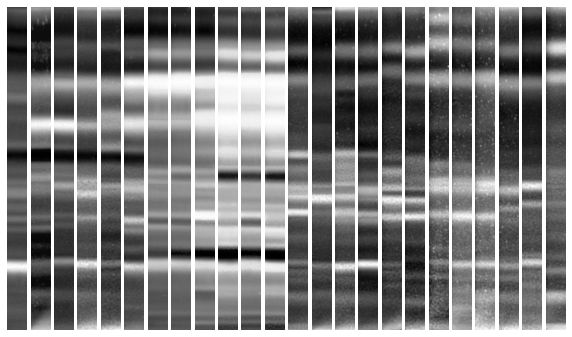

In [17]:
fig = plt.figure(figsize=(10, 10))  # width, height in inches
for i in range(24):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    sub.imshow(strip_array[i],cmap='gray') #, interpolation='nearest'
plt.tight_layout


##### Transforming each Strip in array to a 1D Vector by getting average value of each row

In [18]:
strip_row_avg = []

for i, strip in enumerate(strip_array):
    strip_row_avg.append([])
    for row in strip:
        strip_row_avg[i].append(row.mean())


In [19]:
np.shape(strip_row_avg[0])

(1075,)

In [20]:
np.shape(np.transpose([strip_row_avg[i] for k in range(65)]))

(1075, 65)

#### Plotting arrays of average values to verify mean of each row

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

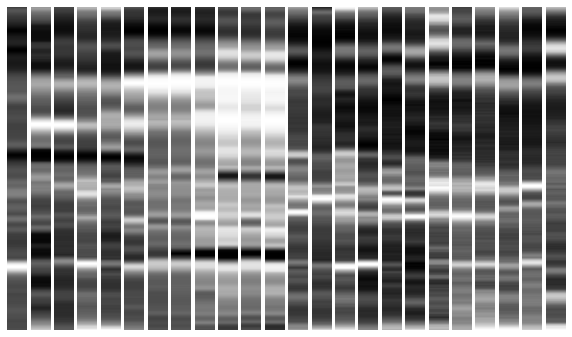

In [21]:
fig = plt.figure(figsize=(10, 10))  # width, height in inches
for i in range(24):
    sub = fig.add_subplot(1, 24, i + 1)
    sub.axis('off')
    img = [strip_row_avg[i] for k in range(65)]
    img = np.transpose(img)
    sub.imshow(img, cmap='gray') #, interpolation='nearest'
plt.tight_layout

In [49]:
# pd.DataFrame(strip_row_avg)

In [167]:
# 1 (GG): Rows 1 - 6 
# 2 (GI): Rows 7 - 12
# 3 (GU): Rows 13 - 18
# 4 (GE): Rows 19 - 21
# 5 (GL): Rows 22 - 24
map = {1:'GG',2:'GI',3:'GU',4:'GE',5:'GL'}
print(map[4])

GE


##### Append Targets to feature array

In [168]:
for i in range(6):
    strip_row_avg[i].append(1)
for i in range(6,12):
    strip_row_avg[i].append(2)
for i in range(12,18):
    strip_row_avg[i].append(3)
for i in range(18,21):
    strip_row_avg[i].append(4)
for i in range(21,24):
    strip_row_avg[i].append(5)

In [169]:
strip_row_avg = pd.DataFrame(strip_row_avg)

##### Get Feature Datafram

In [170]:
df_feat = strip_row_avg.iloc[:,:-2]
np.shape(df_feat)

(24, 1074)

##### Get Target Dataframe

In [173]:
df_target = strip_row_avg.iloc[:,-1:]
np.shape(df_target)
# df_target

(24, 1)

In [432]:
X_train, X_test, y_train, y_test = train_test_split(df_feat, np.ravel(df_target), test_size=1, random_state=103)

In [430]:
X_train = df_feat.drop(23)
y_train = df_target.drop(23)
X_test = pd.array(df_feat.iloc[23])
y_test = pd.array(df_target.iloc[23])

In [433]:
model = SVC()

In [434]:
model.fit(X_train,y_train)

SVC()

In [435]:
predictions = model.predict(X_test)

In [440]:
print('Target: '+str(y_test))
print('Prediction: '+str(predictions))
count = 0
if y_test[0] != predictions[0]:
    count += 1
print(count)

Target: [5]
Prediction: [3]
1


In [448]:
count = 0
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(df_feat, np.ravel(df_target), test_size=1)
    model = SVC()
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    if y_test[0] == predictions[0]:
        count += 1
print(count)

50


In [370]:
# print(confusion_matrix(y_test,predictions))

In [371]:
# print(classification_report(y_test,predictions))